In [17]:
import os
from PIL import Image
from tqdm import tqdm
import hashlib
import numpy as np

from PIL import Image
#import imagehash

#from here https://github.com/JohannesBuchner/imagehash/blob/master/imagehash/__init__.py
#Author Johannes Buchner
#I put the function definitions in so you don't have to install imagehash
try:
    ANTIALIAS = Image.Resampling.LANCZOS
except AttributeError:
    # deprecated in pillow 10
    # https://pillow.readthedocs.io/en/stable/deprecations.html
    ANTIALIAS = Image.ANTIALIAS

def _binary_array_to_hex(arr):
    """
    internal function to make a hex string out of a binary array.
    """
    bit_string = ''.join(str(b) for b in 1 * arr.flatten())
    width = int(np.ceil(len(bit_string) / 4))
    return '{:0>{width}x}'.format(int(bit_string, 2), width=width)

def perceptual_hash(image_path, hash_size=8, highfreq_factor=4):
    # type: (Image.Image, int, int) -> ImageHash
    """
    Perceptual Hash computation.

    Implementation follows https://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html

    @image must be a PIL instance.
    """
    if hash_size < 2:
        raise ValueError('Hash size must be greater than or equal to 2')

    image = Image.open(image_path)
    import scipy.fftpack
    img_size = hash_size * highfreq_factor
    image = image.convert('L').resize((img_size, img_size), ANTIALIAS)
    pixels = np.asarray(image)
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dctlowfreq = dct[:hash_size, :hash_size]
    med = np.median(dctlowfreq)
    diff = dctlowfreq > med
    return _binary_array_to_hex(diff)


#def perceptual_hash(image_path, hash_size=8, highfreq_factor=4):
#    return imagehash.phash(Image.open(image_path), hash_size, highfreq_factor)

def avg_hash(image_fns, images_path):
    # image_fns : List of training image files
    img_hashes = {}
    epsilon = 0

    for image_fn1, image_fn2 in zip(image_fns, image_fns[::-1]):
        if image_fn1 == image_fn2:
            continue

        hash1 = imagehash.average_hash(Image.open(os.path.join(images_path, image_fn1)))
        hash2 = imagehash.average_hash(Image.open(os.path.join(images_path, image_fn2)))
        if hash1 - hash2 < epsilon:
            print( '{} is near duplicate of {}'.format(image_fn1, image_fn2) )

import hashlib
def compute_file_hash(file_path):
    """Compute MD5 hash of a file."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def compute_file_hash_sha512(file_path):
    """Compute Sha512 hash of a file."""
    data = np.array(Image.open(file_path)).tobytes()
    hash_sha512 = hashlib.sha512(data)

    return hash_sha512.hexdigest()

# Hash function to generate a hash based on image content
def image_hash(image_path):
    with Image.open(image_path) as img:
        # Convert image to grayscale and resize to a smaller size for faster hashing
        img = img.convert('L').resize((64, 64), resample=Image.LANCZOS)
        pixels = list(img.getdata())
        avg_pixel = sum(pixels) // len(pixels)
        bits = "".join(['1' if pixel > avg_pixel else '0' for pixel in pixels])
        hash_value = int(bits, 2)
    return hash_value

def image_dhash(image_path, hash_size=8):
    # convert the image to grayscale and resize the grayscale image,
    # adding a single column (width) so we can compute the horizontal
    # gradient
    with Image.open(image_path) as image:
        image = image.convert('L').resize((hash_size + 1, hash_size), resample=Image.LANCZOS)
        # compute the (relative) horizontal gradient between adjacent
        # column pixels
        pixels = np.asarray(image)
        # compute differences between columns
        diff = pixels[:, 1:] > pixels[:, :-1]
        # convert the difference image to a hash and return it
        return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])
    return 0/0

#compares grayscale resized image pixel for pixel 
def image_gray_resize(image_path):
    with Image.open(image_path) as image:
        image.convert('L')
        image.resize((256, 256), resample=Image.NEAREST)
        return np.array(image).flatten()

In [18]:
import os
from tqdm import tqdm

# Function to check for identical images between two datasets
def check_for_identical_images_between_datasets(dataset1_path, dataset2_path):

    # Get all image files from both datasets
    dataset1_files = sorted([f for f in os.listdir(dataset1_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    dataset2_files = sorted([f for f in os.listdir(dataset2_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    dataset1_hashes = {}  # Dictionary to store hashes of dataset1 images
    identical_images = []  # List to store pairs of identical images

    # Compute hashes for all images in dataset1
    for img_file in tqdm(dataset1_files, desc="Processing Dataset 1"):
        img_path = os.path.join(dataset1_path, img_file)
        img_hash = perceptual_hash(img_path)
        dataset1_hashes[img_hash] = img_file

    # Check for identical images in dataset2
    for img_file in tqdm(dataset2_files, desc="Processing Dataset 2"):
        img_path = os.path.join(dataset2_path, img_file)
        img_hash = perceptual_hash(img_path)

        if img_hash in dataset1_hashes:
            identical_images.append((dataset1_hashes[img_hash], img_file))
            print(f"Identical image found: {dataset1_hashes[img_hash]} (in Dataset 1) and {img_file} (in Dataset 2)")

    # Summary of results
    print(f"Finished processing datasets.")
    if identical_images:
        print(f"Found {len(identical_images)} identical images:")
        for img1, img2 in identical_images:
            print(f"{img1} (in Dataset 1) is identical to {img2} (in Dataset 2)")
    else:
        print("No identical images found between the two datasets.")

In [20]:
# Example usage:

root = "/scratch/aniemcz/CAT2/CAT/"

mixed_test_path = os.path.join(root, "mixed", "Test", "annos")
mixed_train_path = os.path.join(root, "mixed", "Train", "annos")

check_for_identical_images_between_datasets(mixed_test_path, mixed_train_path)

Processing Dataset 2:   1%|▏         | 18/1268 [00:00<00:14, 85.28it/s]

Identical image found: anno_108.jpg (in Dataset 1) and anno_109.jpg (in Dataset 2)


Processing Dataset 2:   6%|▋         | 82/1268 [00:00<00:13, 88.70it/s]

Identical image found: anno_182.jpg (in Dataset 1) and anno_181.jpg (in Dataset 2)


Processing Dataset 2:  26%|██▋       | 336/1268 [00:04<00:13, 68.65it/s] 

Identical image found: anno_70.jpg (in Dataset 1) and anno_71.jpg (in Dataset 2)


Processing Dataset 2:  30%|███       | 386/1268 [00:05<00:06, 134.17it/s]

Identical image found: anno_pln_100.jpg (in Dataset 1) and anno_pln_101.jpg (in Dataset 2)


Processing Dataset 2:  35%|███▌      | 444/1268 [00:05<00:04, 168.40it/s]

Identical image found: anno_pln_1089.jpg (in Dataset 1) and anno_pln_1090.jpg (in Dataset 2)
Identical image found: anno_pln_8.jpg (in Dataset 1) and anno_pln_11.jpg (in Dataset 2)
Identical image found: anno_pln_1109.jpg (in Dataset 1) and anno_pln_1108.jpg (in Dataset 2)
Identical image found: anno_pln_1109.jpg (in Dataset 1) and anno_pln_1110.jpg (in Dataset 2)
Identical image found: anno_pln_1124.jpg (in Dataset 1) and anno_pln_1125.jpg (in Dataset 2)
Identical image found: anno_pln_1132.jpg (in Dataset 1) and anno_pln_1133.jpg (in Dataset 2)
Identical image found: anno_pln_115.jpg (in Dataset 1) and anno_pln_114.jpg (in Dataset 2)


Processing Dataset 2:  40%|███▉      | 502/1268 [00:05<00:04, 181.71it/s]

Identical image found: anno_pln_115.jpg (in Dataset 1) and anno_pln_116.jpg (in Dataset 2)


Processing Dataset 2:  43%|████▎     | 540/1268 [00:06<00:04, 180.57it/s]

Identical image found: anno_pln_1216.jpg (in Dataset 1) and anno_pln_1215.jpg (in Dataset 2)
Identical image found: anno_pln_1216.jpg (in Dataset 1) and anno_pln_1217.jpg (in Dataset 2)
Identical image found: anno_pln_1254.jpg (in Dataset 1) and anno_pln_1253.jpg (in Dataset 2)


Processing Dataset 2:  48%|████▊     | 603/1268 [00:06<00:03, 198.06it/s]

Identical image found: anno_pln_1282.jpg (in Dataset 1) and anno_pln_1283.jpg (in Dataset 2)
Identical image found: anno_pln_1288.jpg (in Dataset 1) and anno_pln_1286.jpg (in Dataset 2)
Identical image found: anno_pln_1288.jpg (in Dataset 1) and anno_pln_1287.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1290.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1291.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1292.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1293.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1296.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1297.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1299.jpg (in Dataset 2)
Identical image found: anno_pln_1311.jpg (in Dataset 1) and anno_pln_1

Processing Dataset 2:  52%|█████▏    | 663/1268 [00:06<00:03, 189.95it/s]

Identical image found: anno_pln_174.jpg (in Dataset 1) and anno_pln_173.jpg (in Dataset 2)
Identical image found: anno_pln_185.jpg (in Dataset 1) and anno_pln_186.jpg (in Dataset 2)
Identical image found: anno_pln_213.jpg (in Dataset 1) and anno_pln_212.jpg (in Dataset 2)


Processing Dataset 2:  57%|█████▋    | 721/1268 [00:07<00:03, 182.19it/s]

Identical image found: anno_pln_29.jpg (in Dataset 1) and anno_pln_26.jpg (in Dataset 2)
Identical image found: anno_pln_27.jpg (in Dataset 1) and anno_pln_28.jpg (in Dataset 2)
Identical image found: anno_pln_27.jpg (in Dataset 1) and anno_pln_30.jpg (in Dataset 2)


Processing Dataset 2:  60%|█████▉    | 759/1268 [00:07<00:02, 183.86it/s]

Identical image found: anno_pln_27.jpg (in Dataset 1) and anno_pln_31.jpg (in Dataset 2)
Identical image found: anno_pln_317.jpg (in Dataset 1) and anno_pln_318.jpg (in Dataset 2)
Identical image found: anno_pln_27.jpg (in Dataset 1) and anno_pln_32.jpg (in Dataset 2)
Identical image found: anno_pln_27.jpg (in Dataset 1) and anno_pln_33.jpg (in Dataset 2)
Identical image found: anno_pln_345.jpg (in Dataset 1) and anno_pln_346.jpg (in Dataset 2)


Processing Dataset 2:  65%|██████▍   | 818/1268 [00:07<00:02, 189.62it/s]

Identical image found: anno_pln_361.jpg (in Dataset 1) and anno_pln_362.jpg (in Dataset 2)
Identical image found: anno_pln_366.jpg (in Dataset 1) and anno_pln_367.jpg (in Dataset 2)
Identical image found: anno_pln_366.jpg (in Dataset 1) and anno_pln_368.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_39.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_40.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_41.jpg (in Dataset 2)
Identical image found: anno_pln_411.jpg (in Dataset 1) and anno_pln_410.jpg (in Dataset 2)


Processing Dataset 2:  68%|██████▊   | 858/1268 [00:07<00:02, 193.63it/s]

Identical image found: anno_pln_416.jpg (in Dataset 1) and anno_pln_417.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_42.jpg (in Dataset 2)
Identical image found: anno_pln_427.jpg (in Dataset 1) and anno_pln_426.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_43.jpg (in Dataset 2)
Identical image found: anno_pln_434.jpg (in Dataset 1) and anno_pln_433.jpg (in Dataset 2)
Identical image found: anno_pln_445.jpg (in Dataset 1) and anno_pln_444.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_46.jpg (in Dataset 2)
Identical image found: anno_pln_463.jpg (in Dataset 1) and anno_pln_464.jpg (in Dataset 2)
Identical image found: anno_pln_467.jpg (in Dataset 1) and anno_pln_468.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_47.jpg (in Dataset 2)


Processing Dataset 2:  71%|███████   | 898/1268 [00:07<00:01, 194.74it/s]

Identical image found: anno_pln_474.jpg (in Dataset 1) and anno_pln_472.jpg (in Dataset 2)
Identical image found: anno_pln_474.jpg (in Dataset 1) and anno_pln_475.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_48.jpg (in Dataset 2)
Identical image found: anno_pln_485.jpg (in Dataset 1) and anno_pln_486.jpg (in Dataset 2)
Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_49.jpg (in Dataset 2)
Identical image found: anno_pln_489.jpg (in Dataset 1) and anno_pln_490.jpg (in Dataset 2)
Identical image found: anno_pln_493.jpg (in Dataset 1) and anno_pln_492.jpg (in Dataset 2)
Identical image found: anno_pln_495.jpg (in Dataset 1) and anno_pln_494.jpg (in Dataset 2)
Identical image found: anno_pln_498.jpg (in Dataset 1) and anno_pln_499.jpg (in Dataset 2)
Identical image found: anno_pln_498.jpg (in Dataset 1) and anno_pln_501.jpg (in Dataset 2)
Identical image found: anno_pln_503.jpg (in Dataset 1) and anno_pln_502.jpg (in Dataset 2)
Ide

Processing Dataset 2:  74%|███████▍  | 938/1268 [00:08<00:01, 192.97it/s]

Identical image found: anno_pln_51.jpg (in Dataset 1) and anno_pln_53.jpg (in Dataset 2)
Identical image found: anno_pln_546.jpg (in Dataset 1) and anno_pln_545.jpg (in Dataset 2)
Identical image found: anno_pln_54.jpg (in Dataset 1) and anno_pln_55.jpg (in Dataset 2)
Identical image found: anno_pln_549.jpg (in Dataset 1) and anno_pln_550.jpg (in Dataset 2)
Identical image found: anno_pln_549.jpg (in Dataset 1) and anno_pln_551.jpg (in Dataset 2)
Identical image found: anno_pln_572.jpg (in Dataset 1) and anno_pln_575.jpg (in Dataset 2)
Identical image found: anno_pln_572.jpg (in Dataset 1) and anno_pln_576.jpg (in Dataset 2)


Processing Dataset 2:  77%|███████▋  | 979/1268 [00:08<00:01, 196.07it/s]

Identical image found: anno_pln_62.jpg (in Dataset 1) and anno_pln_58.jpg (in Dataset 2)
Identical image found: anno_pln_592.jpg (in Dataset 1) and anno_pln_587.jpg (in Dataset 2)
Identical image found: anno_pln_591.jpg (in Dataset 1) and anno_pln_589.jpg (in Dataset 2)
Identical image found: anno_pln_591.jpg (in Dataset 1) and anno_pln_590.jpg (in Dataset 2)
Identical image found: anno_pln_8.jpg (in Dataset 1) and anno_pln_6.jpg (in Dataset 2)
Identical image found: anno_pln_59.jpg (in Dataset 1) and anno_pln_60.jpg (in Dataset 2)
Identical image found: anno_pln_621.jpg (in Dataset 1) and anno_pln_611.jpg (in Dataset 2)
Identical image found: anno_pln_621.jpg (in Dataset 1) and anno_pln_612.jpg (in Dataset 2)
Identical image found: anno_pln_621.jpg (in Dataset 1) and anno_pln_614.jpg (in Dataset 2)
Identical image found: anno_pln_621.jpg (in Dataset 1) and anno_pln_618.jpg (in Dataset 2)
Identical image found: anno_pln_621.jpg (in Dataset 1) and anno_pln_620.jpg (in Dataset 2)
Identic

Processing Dataset 2:  82%|████████▏ | 1040/1268 [00:08<00:01, 196.55it/s]

Identical image found: anno_pln_651.jpg (in Dataset 1) and anno_pln_648.jpg (in Dataset 2)
Identical image found: anno_pln_651.jpg (in Dataset 1) and anno_pln_650.jpg (in Dataset 2)
Identical image found: anno_pln_654.jpg (in Dataset 1) and anno_pln_652.jpg (in Dataset 2)
Identical image found: anno_pln_654.jpg (in Dataset 1) and anno_pln_653.jpg (in Dataset 2)
Identical image found: anno_pln_654.jpg (in Dataset 1) and anno_pln_655.jpg (in Dataset 2)
Identical image found: anno_pln_654.jpg (in Dataset 1) and anno_pln_656.jpg (in Dataset 2)
Identical image found: anno_pln_654.jpg (in Dataset 1) and anno_pln_658.jpg (in Dataset 2)
Identical image found: anno_pln_674.jpg (in Dataset 1) and anno_pln_673.jpg (in Dataset 2)
Identical image found: anno_pln_682.jpg (in Dataset 1) and anno_pln_683.jpg (in Dataset 2)
Identical image found: anno_pln_684.jpg (in Dataset 1) and anno_pln_685.jpg (in Dataset 2)


Processing Dataset 2:  85%|████████▌ | 1080/1268 [00:08<00:00, 192.86it/s]

Identical image found: anno_pln_707.jpg (in Dataset 1) and anno_pln_706.jpg (in Dataset 2)
Identical image found: anno_pln_75.jpg (in Dataset 1) and anno_pln_72.jpg (in Dataset 2)
Identical image found: anno_pln_75.jpg (in Dataset 1) and anno_pln_73.jpg (in Dataset 2)
Identical image found: anno_pln_749.jpg (in Dataset 1) and anno_pln_750.jpg (in Dataset 2)
Identical image found: anno_pln_753.jpg (in Dataset 1) and anno_pln_751.jpg (in Dataset 2)
Identical image found: anno_pln_753.jpg (in Dataset 1) and anno_pln_752.jpg (in Dataset 2)
Identical image found: anno_pln_753.jpg (in Dataset 1) and anno_pln_754.jpg (in Dataset 2)
Identical image found: anno_pln_753.jpg (in Dataset 1) and anno_pln_755.jpg (in Dataset 2)


Processing Dataset 2:  88%|████████▊ | 1122/1268 [00:09<00:00, 197.67it/s]

Identical image found: anno_pln_75.jpg (in Dataset 1) and anno_pln_76.jpg (in Dataset 2)
Identical image found: anno_pln_762.jpg (in Dataset 1) and anno_pln_760.jpg (in Dataset 2)
Identical image found: anno_pln_762.jpg (in Dataset 1) and anno_pln_761.jpg (in Dataset 2)
Identical image found: anno_pln_762.jpg (in Dataset 1) and anno_pln_763.jpg (in Dataset 2)
Identical image found: anno_pln_772.jpg (in Dataset 1) and anno_pln_765.jpg (in Dataset 2)
Identical image found: anno_pln_772.jpg (in Dataset 1) and anno_pln_766.jpg (in Dataset 2)
Identical image found: anno_pln_772.jpg (in Dataset 1) and anno_pln_768.jpg (in Dataset 2)
Identical image found: anno_pln_772.jpg (in Dataset 1) and anno_pln_770.jpg (in Dataset 2)
Identical image found: anno_pln_777.jpg (in Dataset 1) and anno_pln_778.jpg (in Dataset 2)
Identical image found: anno_pln_790.jpg (in Dataset 1) and anno_pln_791.jpg (in Dataset 2)
Identical image found: anno_pln_805.jpg (in Dataset 1) and anno_pln_804.jpg (in Dataset 2)
I

Processing Dataset 2:  92%|█████████▏| 1163/1268 [00:09<00:00, 196.89it/s]

Identical image found: anno_pln_82.jpg (in Dataset 1) and anno_pln_83.jpg (in Dataset 2)
Identical image found: anno_pln_851.jpg (in Dataset 1) and anno_pln_852.jpg (in Dataset 2)
Identical image found: anno_pln_85.jpg (in Dataset 1) and anno_pln_86.jpg (in Dataset 2)
Identical image found: anno_pln_87.jpg (in Dataset 1) and anno_pln_88.jpg (in Dataset 2)


Processing Dataset 2:  96%|█████████▋| 1223/1268 [00:09<00:00, 186.64it/s]

Identical image found: anno_pln_8.jpg (in Dataset 1) and anno_pln_9.jpg (in Dataset 2)
Identical image found: anno_pln_933.jpg (in Dataset 1) and anno_pln_934.jpg (in Dataset 2)


Processing Dataset 2: 100%|██████████| 1268/1268 [00:09<00:00, 128.17it/s]

Identical image found: anno_pln_974.jpg (in Dataset 1) and anno_pln_973.jpg (in Dataset 2)
Identical image found: anno_pln_984.jpg (in Dataset 1) and anno_pln_985.jpg (in Dataset 2)
Finished processing datasets.
Found 143 identical images:
anno_108.jpg (in Dataset 1) is identical to anno_109.jpg (in Dataset 2)
anno_182.jpg (in Dataset 1) is identical to anno_181.jpg (in Dataset 2)
anno_70.jpg (in Dataset 1) is identical to anno_71.jpg (in Dataset 2)
anno_pln_100.jpg (in Dataset 1) is identical to anno_pln_101.jpg (in Dataset 2)
anno_pln_1089.jpg (in Dataset 1) is identical to anno_pln_1090.jpg (in Dataset 2)
anno_pln_8.jpg (in Dataset 1) is identical to anno_pln_11.jpg (in Dataset 2)
anno_pln_1109.jpg (in Dataset 1) is identical to anno_pln_1108.jpg (in Dataset 2)
anno_pln_1109.jpg (in Dataset 1) is identical to anno_pln_1110.jpg (in Dataset 2)
anno_pln_1124.jpg (in Dataset 1) is identical to anno_pln_1125.jpg (in Dataset 2)
anno_pln_1132.jpg (in Dataset 1) is identical to anno_pln_113

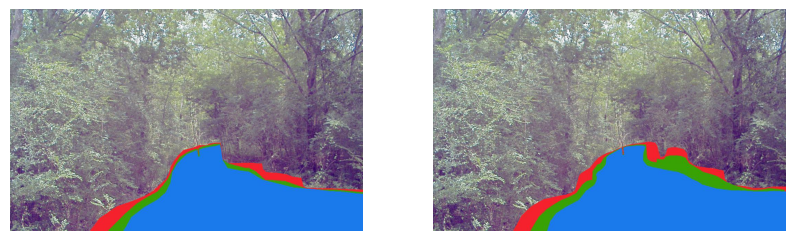

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

image1_path = os.path.join(mixed_test_path, 'anno_108.jpg')
image2_path = os.path.join(mixed_train_path, 'anno_109.jpg')

# Load two images
image1 = Image.open(image1_path)
image2 = Image.open(image2_path)

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first subplot
axes[0].imshow(image1)
axes[0].axis('off')  # Hide the axis

# Display the second image on the second subplot
axes[1].imshow(image2)
axes[1].axis('off')  # Hide the axis

# Display the images
plt.show()